# Laboratorio: Eliminación de anomalías y ajuste de intensidad en imágenes
- UNIR: Maestría en Inteligencia Artificial
- Asignatura: Percepción Computacional
- Alumno: José Manuel Barraza Aispuro
- Fecha: 19/Junio/2024


- __Leer imagen__

Usaremos el modulo "io" de la biblioteca para leer nuestra imagen

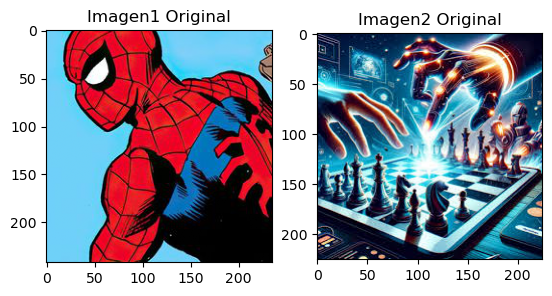

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, color

spiderman = "imagenes/spiderman.jpg"
ajedrez = "imagenes/ajedrez.jpg"

# Cargar la imagen
imagen1 = io.imread( spiderman )/255.0 # imread lee las imagenes con los pixeles codificados como enteros 
# en el rango 0-255. Por eso la convertimos a flotante y en el rango 0-1

imagen2 = io.imread( ajedrez )/ 255.0

plt.subplot(1, 2, 1)
plt.title("Imagen1 Original")
plt.imshow(imagen1,vmin=0,vmax=1)

plt.subplot(1, 2, 2)
plt.title("Imagen2 Original")
plt.imshow(imagen2,vmin=0,vmax=1)

# Eliminación de Anomalías

- __Sal y pimineta__

Recorreremos la imagen coloreando pixeles negros y blancos de forma aleatoria.

(-0.5, 224.5, 224.5, -0.5)

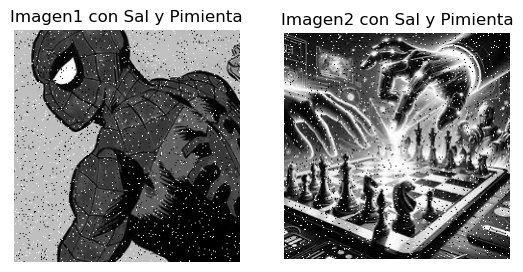

In [6]:
import random

def sal_y_pimienta(imagen, porcentaje):
    
    if len(imagen.shape) == 3:  # Si la imagen tiene tres dimensiones (es una imagen en color)
        h, w, c = imagen.shape
    elif len(imagen.shape) == 2:  # Si la imagen tiene dos dimensiones (es una imagen en escala de grises)
        h, w = imagen.shape
        c = 1
    else:
        raise ValueError("La imagen tiene un formato no compatible.")
        
    imagen_sal_pimienta=np.copy(imagen) # creamos una matriz donde generar la imagen

    porcentaje_pixel_negro = porcentaje * 0.001
    porcentaje_pixel_blanco = 1 - porcentaje * 0.001

    for i in range(h):
        for j in range(w):
            rnd = random.random()
            if rnd < porcentaje_pixel_negro:
                # Añadir ruido de pimienta (píxel negro)
                if c == 3:  # Si la imagen es a color
                    imagen_sal_pimienta[i, j, :] = 0
                else:  # Si la imagen es en escala de grises
                    imagen_sal_pimienta[i, j] = 0
            elif rnd > porcentaje_pixel_blanco:
                # Añadir ruido de sal (píxel blanco)
                if c == 3:  # Si la imagen es a color
                    imagen_sal_pimienta[i, j, :] = 1
                else:  # Si la imagen es en escala de grises
                    imagen_sal_pimienta[i, j] = 1
    return imagen_sal_pimienta

# Agregar ruido de sal y pimienta
imagen1_ruido = sal_y_pimienta(color.rgb2gray(imagen1), 25)
imagen2_ruido = sal_y_pimienta(color.rgb2gray(imagen2), 25)

# Mostrar la imagen
plt.subplot(1, 2, 1)
plt.title("Imagen1 con Sal y Pimienta")
plt.imshow(imagen1_ruido, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Imagen2 con Sal y Pimienta")
plt.imshow(imagen2_ruido, cmap='gray')
plt.axis('off')

Hay una parte en la convolución que tiene cierta dificultad la cual se puede solucionar de varias formas, la parte del padding de la imagen resulta en otro problema a resolver en el proceso de convolución ya que el kernel buscará fuera de ka matriz lo que nos regresaria en un error de Null Pointer Exception, al principio pensé en resolverlo con condicionales, donde si el eje "x" o el eje "y" era igual a cero y culaquiera de los ejes llegaba al index final entonces se evitaba ese index para no procesarlo, otra idea era detectar que, si el pixel pivote es una esquina o es parte del lateral tendria otra forma de procesar el kernel en cada caso lo cual sería mucho codigo, muchas condicionales, nada optimo; eliminar el padding fue la idea ganadora, recorrer el rango de la imagen sin el padding nos deja con la oportunidad de  acceder a los index del padding sin que nos marque un erro, todo estaría bien excepto por um pequeño detalle, se elimino la sal y pimienta execpto por el padding donde aun se podía notar la anomalia, para lo cual busqué recorrer el padding para darles tonos blancos, un pequeño truco que desde una critica constructiva podría considerarse trampa, mala practica, lo recomendable sería añadir un margen con tonos oscuros o blancos para poder realizar la convolucion y despues eliminar ese mismo margen.
- __Recorrer una matriz sin el padding__

In [8]:
# Recorrer una matriz sin el padding
for i in range(1, 3):  # i va de 1 a 3
    for j in range(1, 3):  # j va de 1 a 3
        print("i:", i, "j:", j)

i: 1 j: 1
i: 1 j: 2
i: 2 j: 1
i: 2 j: 2


- __Recorrer padding de una matriz__

In [10]:
# Recorrer padding de una matriz
n=4
for i in range(n):
    for j in range(n):
        
        # recorrer solo el borde
        if i == 0 or i == n-1 or j == 0 or j == n-1:  
            print("i:", i, "j:", j)

i: 0 j: 0
i: 0 j: 1
i: 0 j: 2
i: 0 j: 3
i: 1 j: 0
i: 1 j: 3
i: 2 j: 0
i: 2 j: 3
i: 3 j: 0
i: 3 j: 1
i: 3 j: 2
i: 3 j: 3


- __Convolucion: Filtro Mediana (propio)__

Para implementar la convolución del filtro de la mediana se recorre la imagen que nos llega como parametro
y en cada pixel, utilizando un kernel de 3x3, se obtendrá el muestreo de los pixeles que estan alrededor
de nuestro pixel pivote capturando la informacion en el kernel, usando numpy podremos obtener la mediana
de nuestro kernel asignando este valor a nuestra nueva imagen en el pixel que se asemejará a la posición 
donde se encuentra nuestro pixel pivote.

In [12]:
def convolucion(imagen):
    h, w = imagen.shape
    kernel_3x3 = np.ones((3, 3), np.float32) / 9
    kh, kw = kernel_3x3.shape
    
    imagen_filtro=np.copy(imagen) # creamos una matriz donde generar la imagen

    # Proceso de convolucion
    for i in range(1,h-1):
        for j in range(1,w-1):
            kernel_3x3[0,0] = imagen[i-1,j-1]
            kernel_3x3[0,1] = imagen[i-1, j ]
            kernel_3x3[0,2] = imagen[i-1,j+1]
            kernel_3x3[1,0] = imagen[ i ,j-1]
            kernel_3x3[1,1] = imagen[ i , j ]
            kernel_3x3[1,2] = imagen[ i ,j+1]
            kernel_3x3[2,0] = imagen[i+1,j-1]
            kernel_3x3[2,1] = imagen[i+1, j ]
            kernel_3x3[2,2] = imagen[i+1,j+1]
            imagen_filtro[i,j] = np.median(kernel_3x3)

    # Pintamos los bordes de blanco 1
    for i in range(h):
        for j in range(w):
            if i == 0 or i == h-1 or j == 0 or j == w-1:  # recorrer solo el borde
                imagen_filtro[i,j] = 1

    return imagen_filtro


- __Convolucion: Filtro Mediana (OpenCV)__

Haciendo uso de la biblioteca de OpenCV aplicamos el filtro de media para así comparar resultados contra nuestro filtro de mediana.

In [14]:
#-------- Propio --------
# Aplcar filtro convolucion
imagen1_filtro = convolucion(imagen1_ruido)
imagen2_filtro = convolucion(imagen2_ruido)

import cv2

# Generar ruido "sal y pimienta"
imagen1_ruido = sal_y_pimienta(color.rgb2gray(imagen1), 25)
imagen2_ruido = sal_y_pimienta(color.rgb2gray(imagen2), 25)


#-------- OpenCV --------
# Convertir imagen con ruido a uint8
imagen1_ruido_uint8 = (imagen1_ruido * 255).astype(np.uint8)
imagen2_ruido_uint8 = (imagen2_ruido * 255).astype(np.uint8)

# Aplicar filtro de mediana
#filtro_mediana = cv2.medianBlur(imagen_con_ruido_uint8, 3)

# Aplicar filtro de media (promedio)
imagen1_cv2_media = cv2.blur(imagen1_ruido_uint8, (3, 3))
imagen2_cv2_media = cv2.blur(imagen2_ruido_uint8, (3, 3))

## Imprimir Imagenes - Eliminación de anomalías

(-0.5, 224.5, 224.5, -0.5)

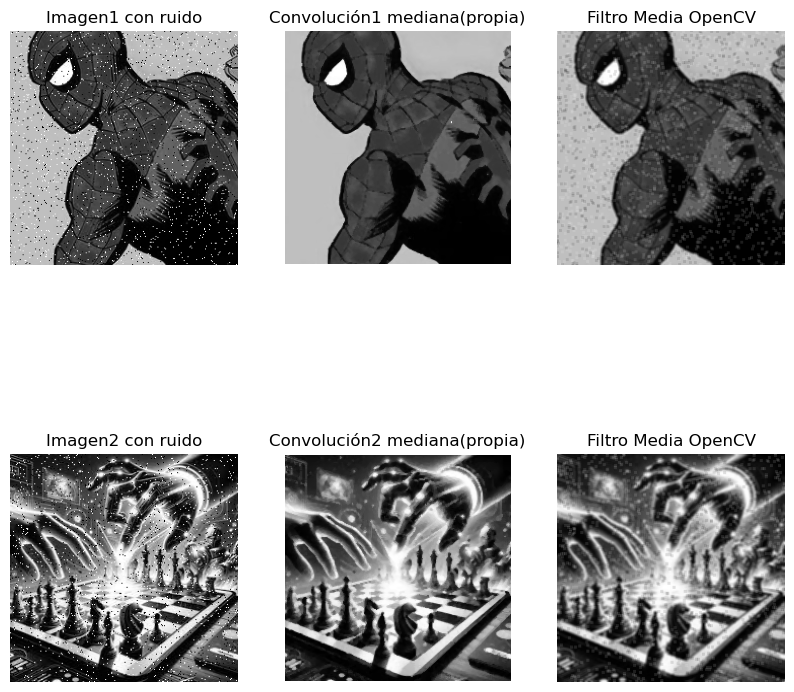

In [16]:
# --- Mostrar imágenes ---
plt.figure(figsize=(10, 10))  # Ajustar tamaño de la figura
plt.subplot(2, 3, 1)
plt.title("Imagen1 con ruido")
plt.imshow(imagen1_ruido, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title("Convolución1 mediana(propia)")
plt.imshow(imagen1_filtro, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(imagen1_cv2_media, cmap='gray')
plt.title("Filtro Media OpenCV")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title("Imagen2 con ruido")
plt.imshow(imagen2_ruido, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title("Convolución2 mediana(propia)")
plt.imshow(imagen2_filtro, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(imagen2_cv2_media, cmap='gray')
plt.title("Filtro Media OpenCV")
plt.axis('off')

In [17]:
# Calcular el Error Cuadratico Medio
mse1_mediana = np.mean((color.rgb2gray(imagen1) - imagen1_filtro) ** 2)
mse1_media = np.mean((color.rgb2gray(imagen1) - imagen1_cv2_media) ** 2)

mse2_mediana = np.mean((color.rgb2gray(imagen2) - imagen2_filtro) ** 2)
mse2_media = np.mean((color.rgb2gray(imagen2) - imagen2_cv2_media) ** 2)

print("IMAGEN 1:\n")
print("METODO MEDIANA(PROPIO):")
print(f"Error Cuadratico Medio (MSE): {mse1_mediana}")
rmse = np.sqrt(mse1_mediana)
print(f"Raiz cuadrada del error Cuadratico Medio (MSE): {rmse}")
print("\nMETODO MEDIA(OpenCV):")
print(f"Error Cuadratico Medio (MSE): {mse1_media}")
rmse = np.sqrt(mse1_media)
print(f"Raiz cuadrada del error Cuadratico Medio (RMSE): {rmse}")

print("\n\nIMAGEN 2:\n")
print("METODO MEDIANA(PROPIO):")
print(f"Error Cuadratico Medio (MSE): {mse2_mediana}")
rmse = np.sqrt(mse2_mediana)
print(f"Raiz cuadrada del error Cuadratico Medio (MSE): {rmse}")
print("\nMETODO MEDIA(OpenCV):")
print(f"Error Cuadratico Medio (MSE): {mse2_media}")
rmse = np.sqrt(mse2_media)
print(f"Raiz cuadrada del error Cuadratico Medio (RMSE): {rmse}")

IMAGEN 1:

METODO MEDIANA(PROPIO):
Error Cuadratico Medio (MSE): 0.0072892199488400235
Raiz cuadrada del error Cuadratico Medio (MSE): 0.08537692866834706

METODO MEDIA(OpenCV):
Error Cuadratico Medio (MSE): 13118.301542428506
Raiz cuadrada del error Cuadratico Medio (RMSE): 114.53515417734639


IMAGEN 2:

METODO MEDIANA(PROPIO):
Error Cuadratico Medio (MSE): 0.016374247903991116
Raiz cuadrada del error Cuadratico Medio (MSE): 0.12796190020467466

METODO MEDIA(OpenCV):
Error Cuadratico Medio (MSE): 15669.585544800111
Raiz cuadrada del error Cuadratico Medio (RMSE): 125.17821513666071


## Conclusion - Eliminación de Anomalías
A simple vista podemos observar grandes diferencias entre las dos tecnicas aplicadas, por un lado la tecnica de "media" de la biblioteca de OpenCV deja mucho que comentar, podría decirse que logró un proceso parcial al reto de eliminar la anomalia de sal y pimienta en las imagenes, aparenta más un enfoque de filtro de suavisado ya que aun se identifica el ruido de la anomalía que se buscaba erradicar; con respecto a nuestra metrica cuantitativa del Error Cuadratico Medio (MSE) resulta en un valor muy mayor a cero, lo que nos da a entender que la comparasion entre la imagen original y la imagen con el filtro de media no son exactamente iguales ¿qué es lo que pasa? al buscar recorrer la imagen pixel a pixel aplicando una convolución de media con nuestro kernel de 3x3 asignamos en nuestro pixel pivote el promedio de los pixeles vecinos y tranformamos la información en intensidades diferentes, afectando tanto a los pixeles con la anomalia de la sal y pimienta tanto como a los pixeles originales, y es que el filtro se aplica a cada pixel de la imagen, dandonos este efecto de suavisado en las imagenes dejandos rastro del ruido y alterando la información original.

Lo que sería recomendable, buscar un enfoque de homogeneidad entre el pixel pivote y los pixeles vecinos, lo cual sí se puede apreciar en la tecnica de "mediana", esta tecnica sí complace a la vista haber logrado erradicar el ruido de sal y pimienta, el Error Cuadratico Medio (MSE) nos tecnicamente cero, lo que nos deja concluir que la imagen original y la imagen con el filtro de la mediana son iguales; esta tecnica de la mediana, a diferencia de la media, logra encontrar un valor homogeneo entre los pixeles vecinos del pixel pivote dandole un repintado preciso al pixel logrando eliminar la anomalia.

Es interensante dar este primer paso al tratamiento de imagenes, te deja razoar cómo fucnionan los filtros de las aplicaciones que encontramos en las aplicaciones como las camaras, editores de video, redes sociales y demas. Desde este punto podemos ver los filtros como procesos mecanicos aplicados a enfoques especificos que, se pueden extrapolar a modelos de IA que aprendan a aplicar los mejores algoritmos para conseguir cumplir instruccion de la forma mas optima.

# Proceso de Ecualización
## Cálculo del Histograma Original

- __Obtenemos el histograma de la imagen__

In [21]:
def getHistograma(imagen):
    # Calcular el histograma
    hist, bins = np.histogram(imagen.ravel(), bins=256, range=[0, 1])
    return hist, bins

- __Cálculo de Función de Densidad de Probabilidad (PDF)__

In [23]:
def pdf(hist):
    # Obtener el total de la frecuencia
    total_frecuencia = hist.sum()
    # Calcular PDF
    pdf = hist / total_frecuencia
    return pdf

- __Cálculo de la Función de Distribución Acumulativa (CDF):__


In [25]:
def cdf(pdf):
    # Calcular CDF acumulativa
    cdf = np.cumsum(pdf)
    return cdf

- __Normalización de la CDF__

In [27]:
def ncdf(cdf):
    # Normalizar CDF
    ncdf = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
    ncdf = np.round(ncdf).astype(np.uint8)
    return ncdf

- __Mapeo de Intensidades__

In [29]:
def mapeoIntensidad(imagen, ncdf):
    # Crear una copia de la imagen
    imagen_ecualizada = imagen.copy()
    filas, columnas = imagen.shape

    for i in range(filas):
        for j in range(columnas):
            valor_pixel = imagen_ecualizada[i, j]
            valor_acumulado = 0.0
            for k in range(256):
                if valor_pixel >= k / 255.0:
                    valor_acumulado = ncdf[k]
                else:
                    break
            # Asignar el nuevo valor al píxel correspondiente
            imagen_ecualizada[i, j] = valor_acumulado
    
    return imagen_ecualizada

- __Creación de la Imagen Ecualizada:__

In [31]:
def imagenEcualizada(imagen):
    # Calculamos el Histograma
    hist, bins = getHistograma(imagen)

    # Calculamos PDF CDF
    pdf_imagen = pdf(hist)
    cdf_imagen = cdf(pdf_imagen)
    ncdf_imagen = ncdf(cdf_imagen)

    # Ecualizamos la imagen
    imagen_ecualizada = mapeoIntensidad(imagen, ncdf_imagen)

    return imagen_ecualizada

## OpenCV Tranformación Logarítmica

In [33]:
import cv2
import numpy as np

# Leer la imagen en escala de grises
imagen1 = cv2.imread("imagenes/spiderman.jpg", cv2.IMREAD_GRAYSCALE)
imagen2 = cv2.imread("imagenes/ajedrez.jpg", cv2.IMREAD_GRAYSCALE)

# Convertir a tipo float para precisión en las operaciones
imagen1_float = np.float32(imagen1)
imagen2_float = np.float32(imagen2)

# Definir la constante de escala
c1 = 255 / np.log(1 + np.max(imagen1_float))
c2 = 255 / np.log(1 + np.max(imagen2_float))

# Aplicar la transformación logarítmica
imagen1_log = c1 * np.log(1 + imagen1_float)
imagen2_log = c2 * np.log(1 + imagen2_float)

# Normalizar los valores al rango [0, 255]
imagen1_log = np.uint8(np.clip(imagen1_log, 0, 255))
imagen2_log = np.uint8(np.clip(imagen2_log, 0, 255))

## Imprimir imagenes

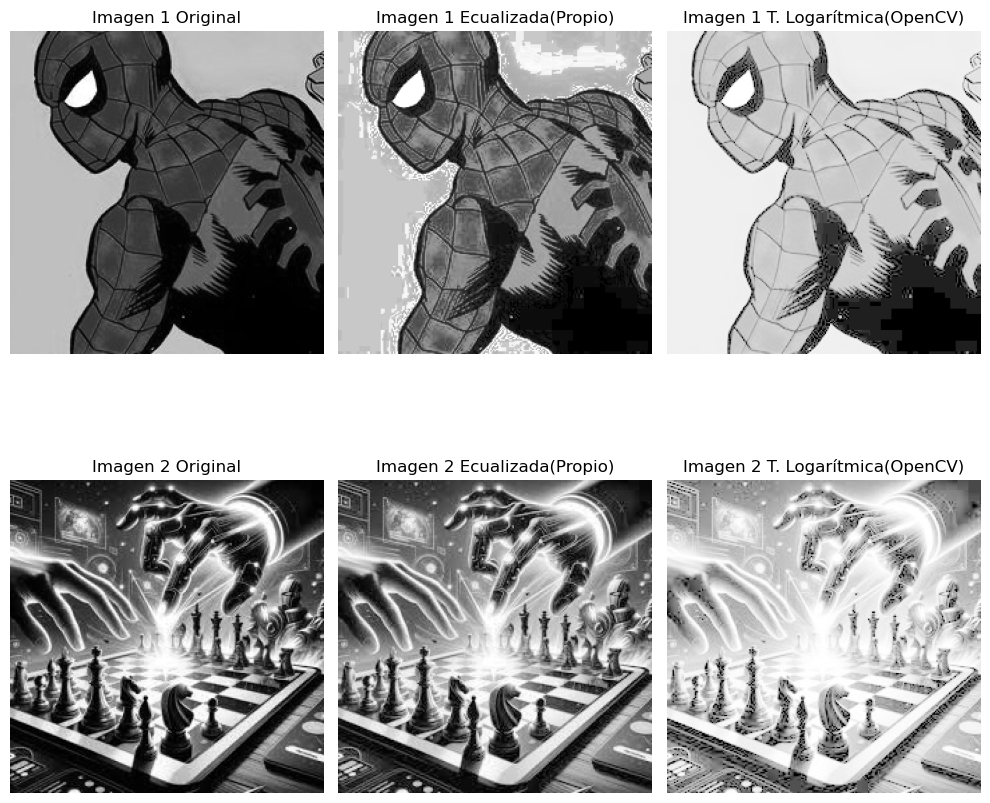

In [35]:
# Cargar una imagen y convertirla a escala de grises
imagen1 = io.imread("imagenes/spiderman.jpg")
imagen1Gris = color.rgb2gray(imagen1)

imagen2 = io.imread("imagenes/ajedrez.jpg")
imagen2Gris = color.rgb2gray(imagen2)

# Ecualizar la imagen en escala de grises
imagen1_ecualizada = imagenEcualizada(imagen1Gris)
imagen2_ecualizada = imagenEcualizada(imagen2Gris)

# Mostrar imagen original
plt.figure(figsize=(10, 10))  # Ajustar tamaño de la figura
plt.subplot(2, 3, 1)
plt.imshow(imagen1Gris, cmap='gray')
plt.title('Imagen 1 Original')
plt.axis('off')

# Mostrar imagen ecualizada
plt.subplot(2, 3, 2)
plt.imshow(imagen1_ecualizada, cmap='gray')
plt.title('Imagen 1 Ecualizada(Propio)')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(imagen1_log, cmap='gray')
plt.title('Imagen 1 T. Logarítmica(OpenCV)')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(imagen2Gris, cmap='gray')
plt.title('Imagen 2 Original')
plt.axis('off')

# Mostrar imagen ecualizada
plt.subplot(2, 3, 5)
plt.imshow(imagen2_ecualizada, cmap='gray')
plt.title('Imagen 2 Ecualizada(Propio)')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(imagen2_log, cmap='gray')
plt.title('Imagen 2 T. Logarítmica(OpenCV)')
plt.axis('off')

plt.tight_layout()
plt.show()

## Comparacion de histogramas

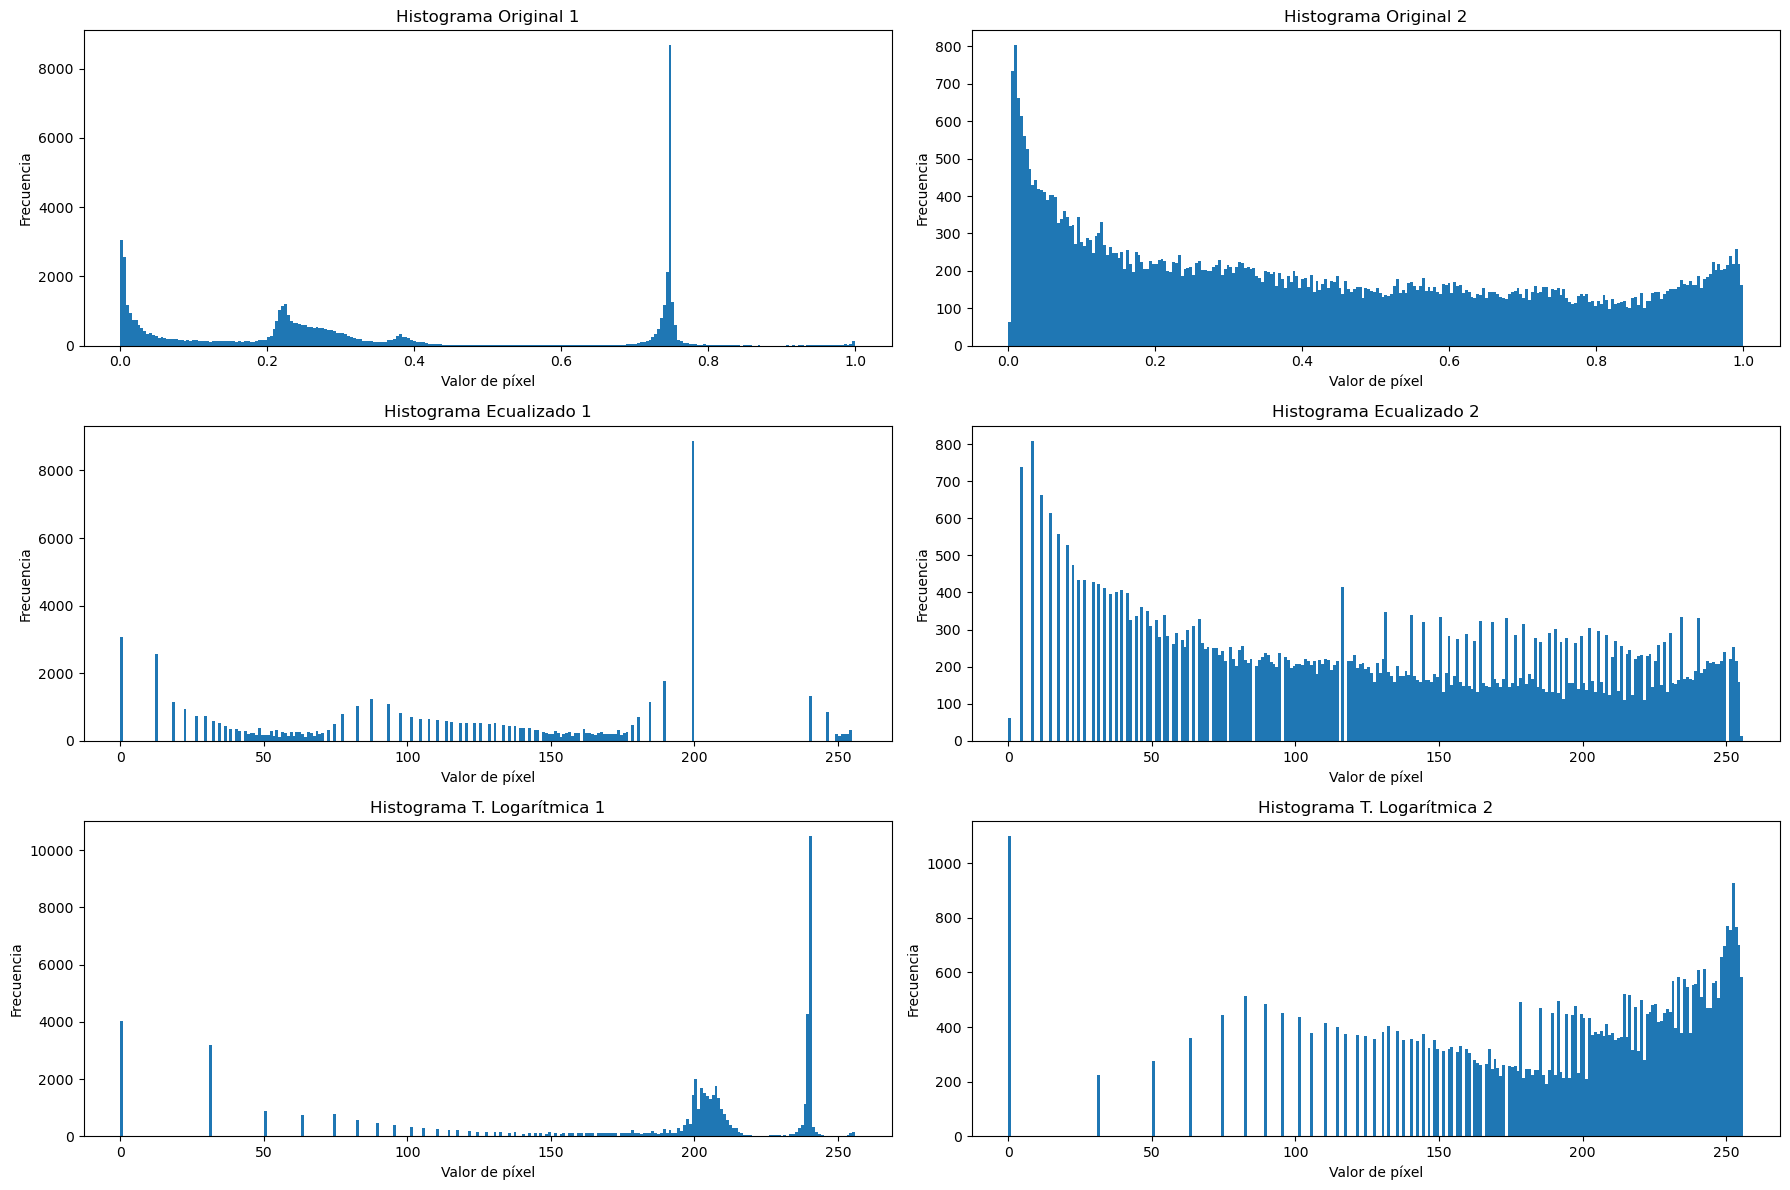

In [37]:
# Mostrar los histogramas
plt.figure(figsize=(18, 12))  # Ajustar tamaño de la figura

# Histograma de la Imagen 1 Original
plt.subplot(3, 2, 1)
plt.hist(imagen1Gris.ravel(), bins=256, range=[0, 1])
plt.title('Histograma Original 1')
plt.xlabel('Valor de píxel')
plt.ylabel('Frecuencia')

# Histograma de la Imagen 1 Ecualizada (Propia)
plt.subplot(3, 2, 3)
plt.hist(imagen1_ecualizada.ravel(), bins=256, range=[0, 256])
plt.title('Histograma Ecualizado 1')
plt.xlabel('Valor de píxel')
plt.ylabel('Frecuencia')

# Histograma de la Imagen 1 Transformación Logarítmica (OpenCV)
plt.subplot(3, 2, 5)# 
plt.hist(imagen1_log.ravel(), bins=256, range=[0, 256])
plt.title('Histograma T. Logarítmica 1')
plt.xlabel('Valor de píxel')
plt.ylabel('Frecuencia')

# Histograma de la Imagen 2 Original
plt.subplot(3, 2, 2)
plt.hist(imagen2Gris.ravel(), bins=256, range=[0, 1])
plt.title('Histograma Original 2')
plt.xlabel('Valor de píxel')
plt.ylabel('Frecuencia')

# Histograma de la Imagen 2 Ecualizada (Propia)
plt.subplot(3, 2, 4)
plt.hist(imagen2_ecualizada.ravel(), bins=256, range=[0, 256])
plt.title('Histograma Ecualizado 2')
plt.xlabel('Valor de píxel')
plt.ylabel('Frecuencia')

# Histograma de la Imagen 2 Transformación Logarítmica (OpenCV)
plt.subplot(3, 2, 6)
plt.hist(imagen2_log.ravel(), bins=256, range=[0, 256])
plt.title('Histograma T. Logarítmica 2')
plt.xlabel('Valor de píxel')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

## Referencias

Mehmood, Salman(2022, junio, 13). Filtro mediano de OpenCV. DelfStack. https://www.delftstack.com/es/howto/python/opencv-median-filter/#google_vignette

Quiroga, Facundo(2017). Tutorial de procesamiento de imágenes con Numpy. Github. https://facundoq.github.io/courses/images/res/04_imagenes_numpy.html

Frost, Jim(2024). Mean Squared Error (MSE).Statistics By Jim. https://statisticsbyjim.com/regression/mean-squared-error-mse/

OpenAI. (2024). ChatGPT (versión del 16 de junio) Transformación Logarítmica OpenCV. https://chat.openai.com/chat